In [1]:
pip install tensorflow numpy matplotlib scikit-learn

In [2]:
import numpy as np
import pandas as pd
import re
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, precision_score, recall_score
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from google.colab import files
uploaded = files.upload()

Saving preprocessed_comments.csv to preprocessed_comments.csv


In [4]:
# Step 1: Load and Preprocess Data
df = pd.read_csv('preprocessed_comments.csv', encoding='latin1')
df.head()

,text,classification
0,people freak,1
1,ben shapiro correct,0
2,wish ben moment coroner would pull dude nut he...,1
3,smart one room wrong room,0
4,would never say someone physical threat cowardly,1


In [5]:
# Assuming the CSV has columns 'text' and 'classification'
texts = df['text'].astype(str).values
labels = df['classification'].values

In [6]:
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r"http\S+", "", text)  # Remove URLs
    text = re.sub(r"[^a-zA-Z0-9\s]", "", text)  # Remove special characters
    return text

In [7]:
texts = [preprocess_text(t) for t in texts]

In [8]:
# Encode labels
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)

# Tokenize and pad the text data
max_words = 10000  # Maximum vocabulary size
max_len = 100      # Maximum sequence length


In [9]:
tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
post_padded_sequences = pad_sequences(sequences, maxlen=max_len, padding='pre', truncating='post')

In [10]:
# Split data into training and testing sets
X_train_pre, X_test_pre, y_train_pre, y_test_pre = train_test_split(
    post_padded_sequences, labels, test_size=0.33, random_state=42
)

In [11]:
# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train_pre), y=y_train_pre)
class_weights = dict(enumerate(class_weights))

In [12]:
# Step 2: Build the Improved RNN Model
rnn_pre = Sequential([
    Embedding(input_dim=max_words, output_dim=64),
    LSTM(64, activation='tanh', return_sequences=True),
    BatchNormalization(),
    Dropout(0.5),
    LSTM(32, activation='tanh', return_sequences=False),
    Dropout(0.5),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')
])

In [13]:
# Compile the model
rnn_pre.compile(optimizer=Adam(learning_rate=0.0005), loss='binary_crossentropy', metrics=['accuracy'])

In [14]:
# Step 3: Train the Model
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = rnn_pre.fit(
    X_train_pre, y_train_pre,
    epochs=20,
    batch_size=64,
    validation_data=(X_test_pre, y_test_pre),
    callbacks=[early_stopping],
    class_weight=class_weights
)

Epoch 1/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 46s 244ms/step - accuracy: 0.5921 - loss: 0.6644 - val_accuracy: 0.6950 - val_loss: 0.6414
Epoch 2/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 44s 282ms/step - accuracy: 0.8306 - loss: 0.4011 - val_accuracy: 0.7705 - val_loss: 0.5404
Epoch 3/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 81s 277ms/step - accuracy: 0.8993 - loss: 0.2737 - val_accuracy: 0.8040 - val_loss: 0.4259
Epoch 4/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 32s 204ms/step - accuracy: 0.9276 - loss: 0.2007 - val_accuracy: 0.8297 - val_loss: 0.4168
Epoch 5/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 39s 189ms/step - accuracy: 0.9475 - loss: 0.1529 - val_accuracy: 0.8158 - val_loss: 0.5340
Epoch 6/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 43s 200ms/step - accuracy: 0.9536 - loss: 0.1372 - val_accuracy: 0.7999 - val_loss: 0.6950
Epoch 7/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 39s 186ms/step - accuracy: 0.9702 - loss: 0.0915 - val_accuracy: 0.8158 - val_loss: 0.6990


In [15]:
# Step 4: Evaluate the Model
loss, accuracy = rnn_pre.evaluate(X_test_pre, y_test_pre)
print(f"Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}")

152/152 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - accuracy: 0.8367 - loss: 0.4204
Test Loss: 0.4168, Test Accuracy: 0.8297


In [16]:
# Get predictions
y_pred_pre = rnn_pre.predict(X_test_pre)
y_pred_pre_class = (y_pred_pre > 0.5).astype('int32')

152/152 ━━━━━━━━━━━━━━━━━━━━ 10s 67ms/step


In [17]:
# Step 5: Evaluate Metrics
f1 = f1_score(y_test_pre, y_pred_pre_class)
precision = precision_score(y_test_pre, y_pred_pre_class)
recall = recall_score(y_test_pre, y_pred_pre_class)

print(f"F1 Score: {f1:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

F1 Score: 0.8655
Precision: 0.8607
Recall: 0.8703


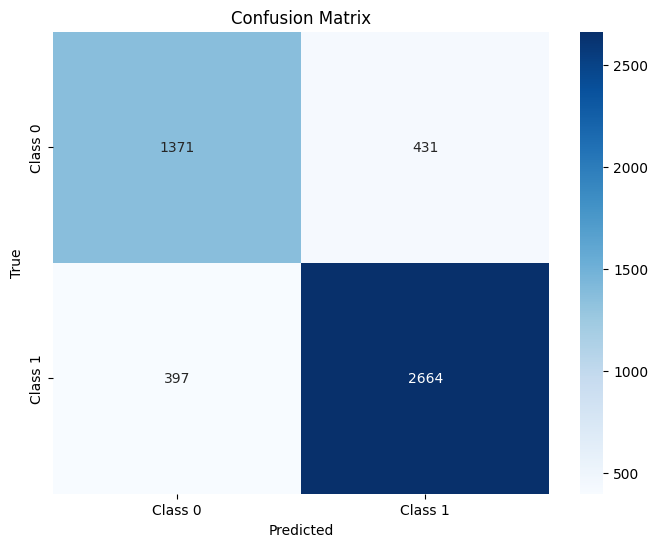

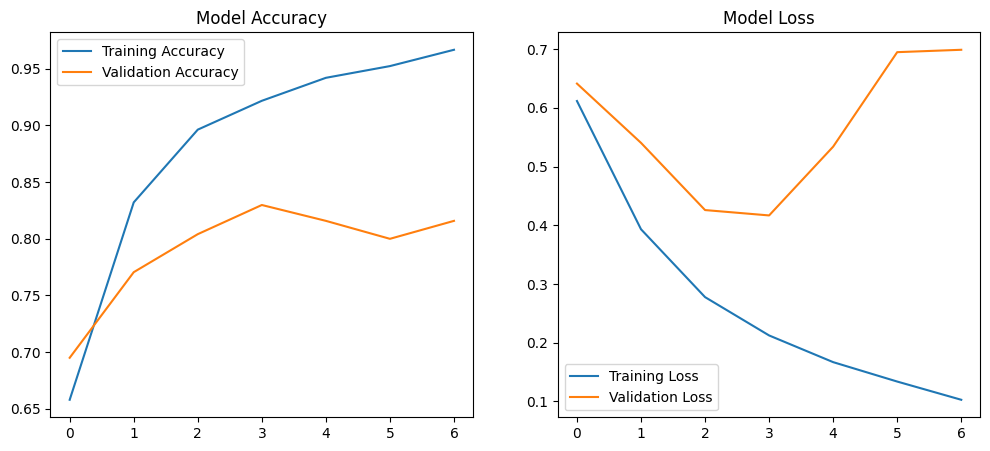

In [18]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test_pre, y_pred_pre_class)
class_names = ['Class 0', 'Class 1']

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Step 6: Visualize Training History
plt.figure(figsize=(12, 5))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.legend()

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.legend()

plt.show()

In [20]:
rnn_pre.save('rnn_model.h5')
files.download('rnn_model.h5')
import pickle

# Save the tokenizer to a file
with open('tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)
files.download('tokenizer.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>